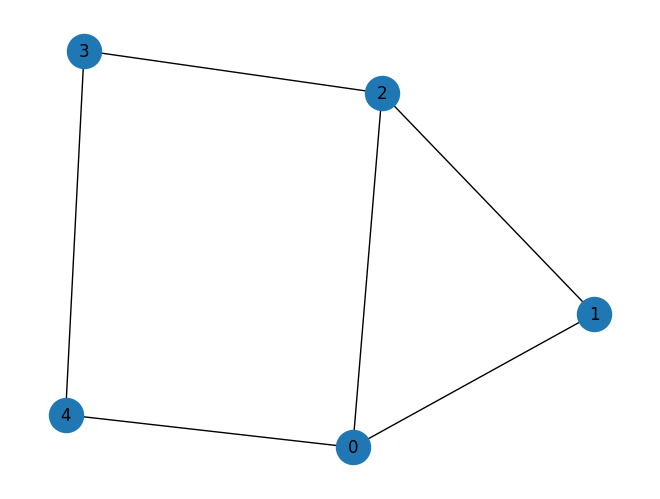

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


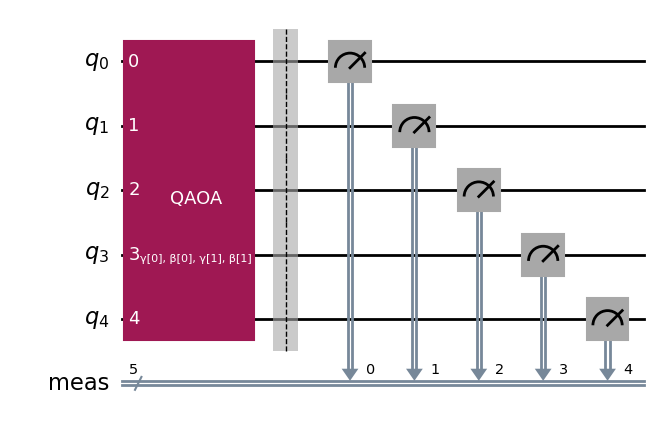

In [3]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')



In [4]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

TSP Hamiltonian:
 SparsePauliOp(['ZZZZZIIIIIIIIIIIIIIIIIIII', 'IIIIIZZZZZIIIIIIIIIIIIIII', 'IIIIIIIIIIZZZZZIIIIIIIIII', 'IIIIIIIIIIIIIIIZZZZZIIIII', 'IIIIIIIIIIIIIIIIIIIIZZZZZ', 'ZIIIIZIIIIZIIIIZIIIIZIIII', 'IZIIIIZIIIIZIIIIZIIIIZIII', 'IIZIIIIZIIIIZIIIIZIIIIZII', 'IIIZIIIIZIIIIZIIIIZIIIIZI', 'IIIIZIIIIZIIIIZIIIIZIIIIZ', 'ZIIIIIZIIIIIIIIIIIIIIIIII', 'IZIIIIIZIIIIIIIIIIIIIIIII', 'IIZIIIIIZIIIIIIIIIIIIIIII', 'IIIZIIIIIZIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIZIIIIIIIIIIIII', 'IZIIIIIIIIIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIZIIIIIIIIII', 'IIIIZIIIIIZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIZIIIIIIII', 'IZIIIIIIIIIIIIIIIZIIIIIII', 'IIZIIIIIIIIIIIIIIIZIIIIII', 'IIIZIIIIIIIIIIIIIIIZIIIII', 'IIIIZIIIIIIIIIIZIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIZIII', 'IZIIIIIIIIIIIIIIIIIIIIZII', 'IIZIIIIIIIIIIIIIIIIIIIIZI', 'IIIZIIIIIIIIIIIIIIIIIIIIZ', 'IIIIZIIIIIIIIIIIIIIIZIIII', 'IIIIIZIIIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIZIIIIIIIIIIII', 'IIIIIIIZIIIIIZIIIIIIIIIII', 'IIIIIIIIZ

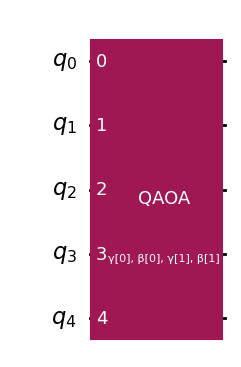

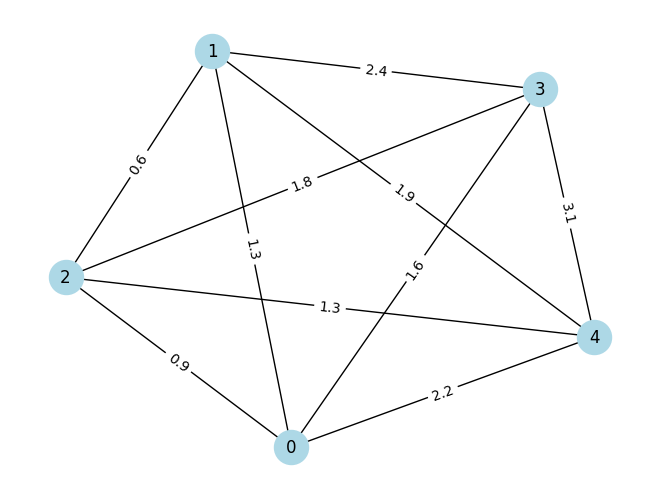

In [5]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import networkx as nx

# --- TSP Problem Definition ---
cities = ["A", "B", "C", "D", "E"]
distance_matrix = np.array([
    [0, 1.3, 0.9, 1.6, 2.2],
    [1.3, 0, 0.6, 2.4, 1.9],
    [0.9, 0.6, 0, 1.8, 1.3],
    [1.6, 2.4, 1.8, 0, 3.1],
    [2.2, 1.9, 1.3, 3.1, 0]
])

# --- Create TSP Graph ---
n = len(cities)
tsp_graph = rx.PyGraph()
tsp_graph.add_nodes_from(range(n))

# Add edges with weights (distances)
for i in range(n):
    for j in range(i+1, n):
        tsp_graph.add_edge(i, j, distance_matrix[i][j])

# Draw the TSP graph
draw_graph(tsp_graph, node_size=600, with_labels=True, 
           node_color='lightblue', edge_labels=lambda x: f"{x:.1f}")

# --- Build TSP Hamiltonian ---
def build_tsp_hamiltonian(graph: rx.PyGraph, penalty=1000) -> SparsePauliOp:
    """Build Hamiltonian for TSP as sum of 3 components"""
    n = len(graph.nodes())
    
    # 1. Constraint: Each city visited exactly once
    h_city = []
    for i in range(n):
        pauli_str = ["I"] * n**2
        for t in range(n):
            idx = i * n + t
            pauli_str[idx] = "Z"
        h_city.append(("".join(pauli_str), penalty * (1 - 2/n)))
    
    # 2. Constraint: Each time slot has exactly one city
    h_time = []
    for t in range(n):
        pauli_str = ["I"] * n**2
        for i in range(n):
            idx = i * n + t
            pauli_str[idx] = "Z"
        h_time.append(("".join(pauli_str), penalty * (1 - 2/n)))
    
    # 3. Objective: Minimize travel distance
    h_dist = []
    for edge in graph.edge_list():
        i, j = edge
        weight = graph.get_edge_data(i, j)
        for t in range(n):
            pauli_str = ["I"] * n**2
            idx_i = i * n + t
            idx_j = j * n + ((t + 1) % n)
            pauli_str[idx_i] = "Z"
            pauli_str[idx_j] = "Z"
            h_dist.append(("".join(pauli_str), weight / 4))
    
    # Combine all terms
    return SparsePauliOp.from_list(h_city + h_time + h_dist)

# Build the Hamiltonian
tsp_hamiltonian = build_tsp_hamiltonian(tsp_graph)
print("TSP Hamiltonian:\n", tsp_hamiltonian)

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
#circuit.measure_all()

circuit.draw('mpl')


In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

In [7]:
service = QiskitRuntimeService()

/tmp/ipykernel_249697/1875822867.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


In [8]:
# Select least busy backend
dev = service.least_busy(min_num_qubits=5, simulator=False, operational=True)
print(dev)

<IBMBackend('ibm_brisbane')>


In [9]:
seed_sim = 42
noisy_fake_backend = AerSimulator.from_backend(dev, seed_simulator=seed_sim)
print(noisy_fake_backend)

AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['measure', 'x', 'reset', 'ecr', 'sx', 'id']>)


In [10]:
pm = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=2)
isa_circuit = pm.run(circuit) 

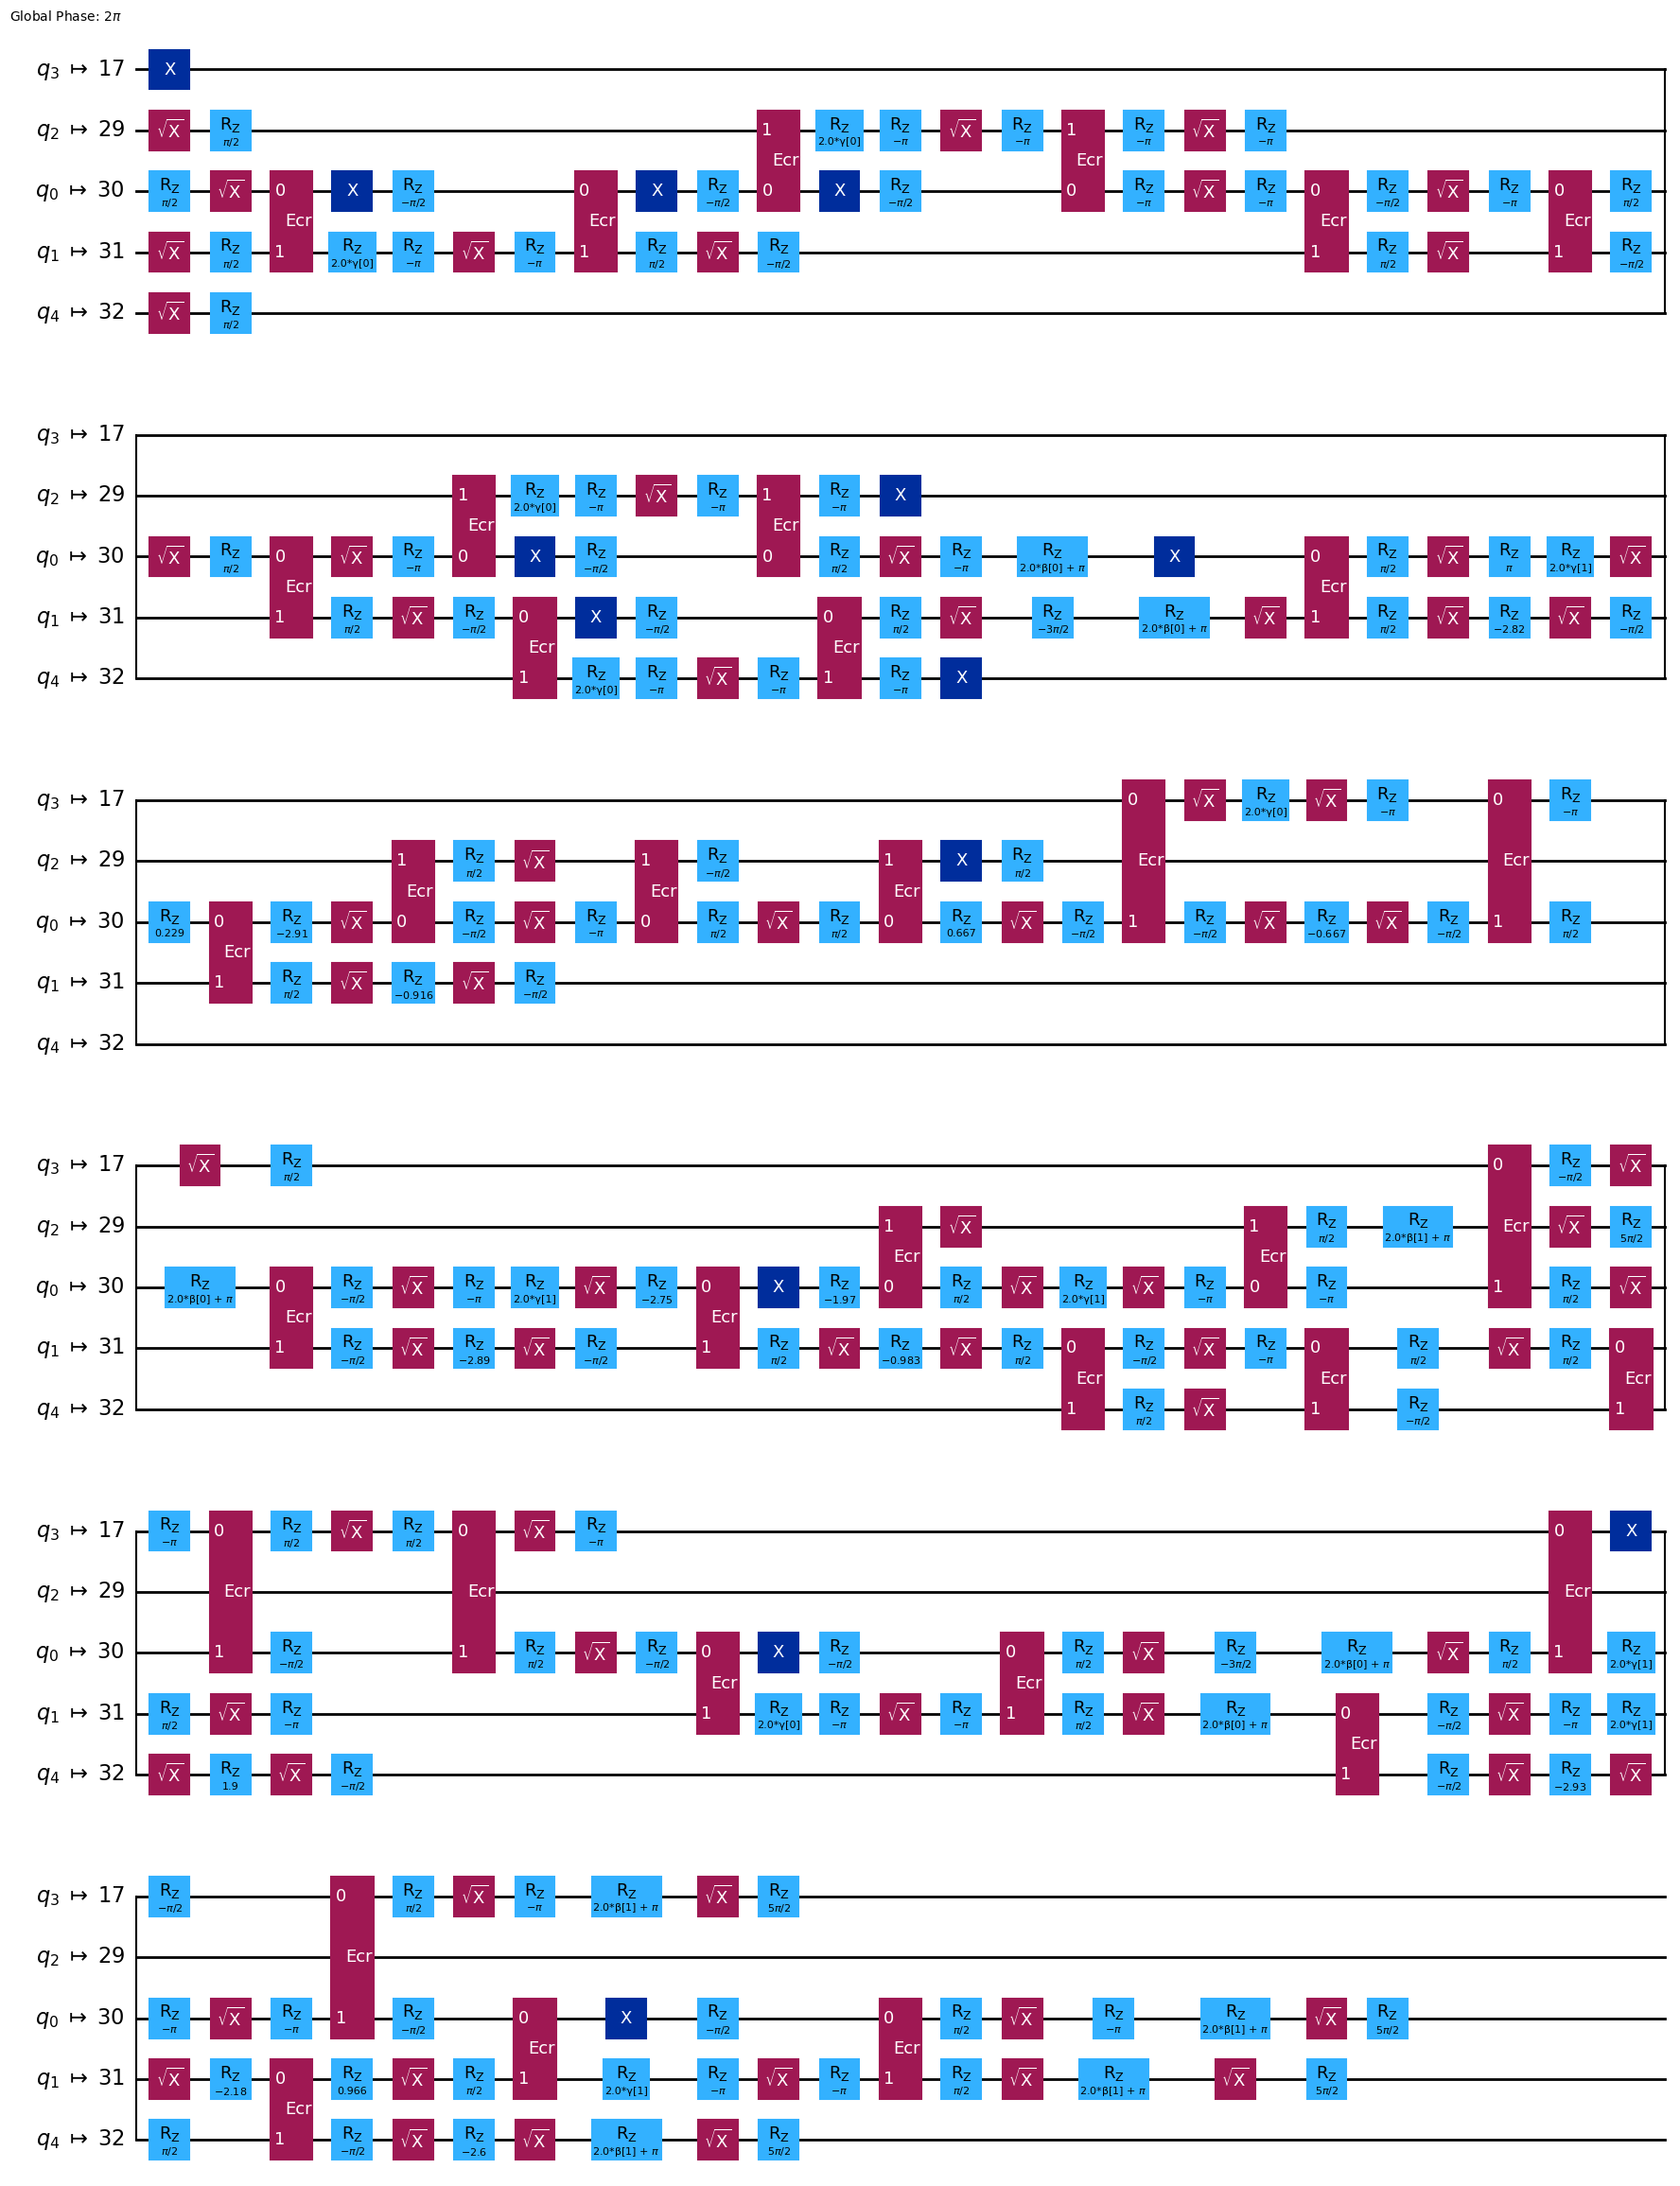

In [11]:
isa_circuit.draw("mpl", idle_wires=False)